## Example 5.4 Cylindrical symmetry problem with internal volume constraint

This example shows the solution of an axi-symmetric problem with an internal constraint.
The domain includes a cavity whose volume is kept constant during the simulation but its shape is arbitrary.

In [1]:
using Printf, PyCall, PyPlot
using AbaqusReader

In [2]:
using AD4SM

a few helper functions to sort the nodes of the internal boundary, calculate the volume of the cavity and quick plotting the solution in the notebook

In [3]:
mean(x) = sum(x)/length(x)
norm(x) = sqrt(sum(x.^2))
#
#
# sort_bnd sorts the nodes of the boundary to 
# form a path without self-intersections
function sort_bnd(nodes, nid_bnd)
  closest(node0, nodes) = findmin([norm(node0-node) for node in nodes])[2]

  id_srtd   = [nid_bnd[1],]
  lastnode  = nid_bnd[1]
  bnd_nodes = nid_bnd[2:end]

  while !isempty(bnd_nodes)
    idd = closest(nodes[lastnode], nodes[bnd_nodes])
    lastnode = bnd_nodes[idd]
    push!(id_srtd, bnd_nodes[idd])
    deleteat!(bnd_nodes, idd)
  end
  return id_srtd
end

# get_vol calculates the volume of the cavity
get_vol(p0) = π/2*sum(
  (p0[2:2:end-2]+p0[4:2:end]) .* 
  (p0[3:2:end]-p0[1:2:end-2]) .* 
  (p0[3:2:end]+p0[1:2:end-2]) )
#
# functions for plotting
#
function get_I1(elems, u0)
    F   = Elements.getinfo(elems,u0,info=:F)
    [ Materials.getInvariants(transpose(F)*F)[1] for F in F] 
end
function get_I3(elems, u0)
    F   = Elements.getinfo(elems,u0,info=:F)
    [ Materials.getInvariants(transpose(F)*F)[3] for F in F] 
end
patch = pyimport("matplotlib.patches")
coll  = pyimport("matplotlib.collections")  
function plot_model(elems, nodes; 
                    u = zeros(length(nodes[1]), length(nodes)),
                    Φ = [],
                    linewidth = 0.25,
                    facecolor = :c,
                    edgecolor = :b, 
                    alpha     = 1,
                    cmap      = :hsv,
                    clim      = [],
                    dTol      = 1e-6,
                    cfig      = figure(),
                    ax        = cfig.add_subplot(1,1,1))

  nodes     = [node + u[:,ii] for (ii,node) in enumerate(nodes)]
  patchcoll = coll.PatchCollection([patch.Polygon(nodes[elem.nodes]) 
                                    for elem ∈ elems], cmap=cmap)
    if !isempty(Φ)
    patchcoll.set_array(Φ)
    cfig.colorbar.(patchcoll, ax=ax)

    if isempty(clim)
      clim = patchcoll.get_clim()
      if abs(clim[2]-clim[1]) < dTol
        clim  = sum(clim)/2*[0.9, 1.1]
      end
    end
    patchcoll.set_clim(clim)
  else
    patchcoll.set_color(facecolor)
  end

  patchcoll.set_edgecolor(edgecolor)
  patchcoll.set_alpha(alpha)
  patchcoll.set_linewidth(linewidth)

  ax.set_aspect("equal")
  ax.add_collection(patchcoll)
  ax.autoscale()
  (cfig, ax, patchcoll)
end
;

In [4]:
sMeshFile = "AxSymDomainj.inp"
mat       = Materials.MooneyRivlin(1e1, 1e1, 1e3)
Δu        = 18
sPosFix   = "NHd"
N         = 200
LF        = range(1/10N, 1, length=N)
dTol      = 1e-6
ballus    = true
;

┌ Info: 916 nodes found
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/C1mY0/src/parse_mesh.jl:109
┌ Info: Parsing elements. Type: CPS4. Topology: Quad4
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/C1mY0/src/parse_mesh.jl:153
┌ Info: Creating nset TOP
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/C1mY0/src/parse_mesh.jl:187
┌ Info: Creating elset TOP
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/C1mY0/src/parse_mesh.jl:187
┌ Info: Creating nset BTM
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/C1mY0/src/parse_mesh.jl:187
┌ Info: Creating elset BTM
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/C1mY0/src/parse_mesh.jl:187
┌ Info: Creating nset BND
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/C1mY0/src/parse_mesh.jl:187
┌ Info: Creating elset BND
└ @ AbaqusReader /home/andrea/.julia/packages/AbaqusReader/C1mY0/src/parse_mesh.jl:187
┌ Info: Creating nset ALL
└ @ AbaqusReader /home/andrea/.julia/pack

(nNodes, nElems) = (length(nodes), length(elems)) = (916, 796)
V0 = get_vol(pos0) = 221925.20483454564


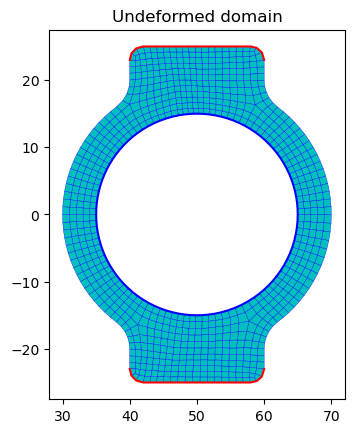

In [5]:
sFileName = splitext(basename(sMeshFile))[1];
mymodel   = AbaqusReader.abaqus_read_mesh(sMeshFile)
nodes     = [mymodel["nodes"][ii] for ii in 1:mymodel["nodes"].count]
el_nodes  = [item[2]              for item in mymodel["elements"]] 

# for node in nodes
#   node[1]-=10
# end

id_btm   = mymodel["node_sets"]["BTM"]
id_top   = mymodel["node_sets"]["TOP"]
id_bnd   = mymodel["node_sets"]["BND"]

elems     = [Elements.ASQuad(item, nodes[item], mat=mat) for item ∈ el_nodes]

@show (nNodes, nElems) = (length(nodes), length(elems)); flush(stdout)

# sort the internal boundary nodes
#
id_srtd   = sort_bnd(nodes, id_bnd);
push!(id_srtd, id_srtd[1])
pos0      = hcat(nodes[id_srtd]...)
idxu      = LinearIndices((2,nNodes))
@show V0  = get_vol(pos0)

pos_btm   = hcat(nodes[sort_bnd(nodes, id_btm)]...)
pos_top   = hcat(nodes[sort_bnd(nodes, id_top)]...)

plot_model(elems, nodes)
PyPlot.plot(pos0[1,:], pos0[2,:], color=:b)        
PyPlot.plot(pos_btm[1,:], pos_btm[2,:], color=:r)        
PyPlot.plot(pos_top[1,:], pos_top[2,:], color=:r)        
PyPlot.title("Undeformed domain")
;

### Solve the model with no cavity volume constraint 

In [6]:
# displacement boundary conditions
u0     = 1e-5randn(2, nNodes)
idxu   = LinearIndices(u0)
bifree = trues(size(u0))

bifree[:,id_btm] .= false
bifree[2,id_top] .= false

u0[:,id_btm] .= 0
u0[2,id_top] .= 0

;

In [7]:
@time Solvers.solvestep!(elems, u0, u0, bifree, dTol=dTol)
;

  9.855981 seconds (30.07 M allocations: 1.590 GiB, 7.14% gc time, 96.97% compilation time)


In [8]:
u            = copy(u0)
u[:,id_btm] .= 0
u[2,id_top] .= -Δu

allus_e = Solvers.solve(elems, u, ifree=bifree, LF=range(1/10N, 1, length=N),
                     becho=true, bechoi=false, ballus=ballus,
                     dTolu=1e-6, dTole=1e-2, maxiter=15)
;

step   1/200, LF=0.001, done in  2 iter, after 0.18 sec.
step   2/200, LF=0.006, done in  2 iter, after 0.17 sec.
step   3/200, LF=0.011, done in  2 iter, after 0.19 sec.
step   4/200, LF=0.016, done in  2 iter, after 0.19 sec.
step   5/200, LF=0.021, done in  2 iter, after 0.19 sec.
step   6/200, LF=0.026, done in  2 iter, after 0.19 sec.
step   7/200, LF=0.031, done in  2 iter, after 0.19 sec.
step   8/200, LF=0.036, done in  2 iter, after 0.19 sec.
step   9/200, LF=0.041, done in  2 iter, after 0.19 sec.
step  10/200, LF=0.046, done in  2 iter, after 0.19 sec.
step  11/200, LF=0.051, done in  2 iter, after 0.19 sec.
step  12/200, LF=0.056, done in  2 iter, after 0.19 sec.
step  13/200, LF=0.061, done in  2 iter, after 0.20 sec.
step  14/200, LF=0.066, done in  2 iter, after 0.20 sec.
step  15/200, LF=0.071, done in  2 iter, after 0.20 sec.
step  16/200, LF=0.076, done in  2 iter, after 0.20 sec.
step  17/200, LF=0.081, done in  2 iter, after 0.20 sec.
step  18/200, LF=0.086, done in

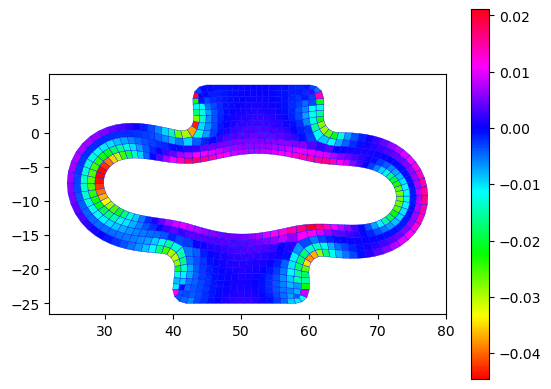

In [9]:
cfig = PyPlot.figure()

ax1  = cfig.add_subplot(1,1,1)
plot_model(elems, nodes, cfig=cfig, ax=ax1, 
  u=allus_e[end][1], Φ=get_I3(elems, allus_e[end][1]).-1)
;

### Solve the model including a constraint on the volume of the cavity

In [10]:
nid_bnd = length(id_srtd)
nDoFsu  = 2*nNodes
q       = 10
nGropus = ceil(Int, nid_bnd/q)

id_eqs_DoFs = [(ii-1)*q+1:ii*q+1 for ii in 1:nGropus-1]
append!(id_eqs_DoFs, [id_eqs_DoFs[end][end]:nid_bnd])

eqns = vcat(
  [begin
      id_bnd_ii = id_srtd[idx]
      idx_ii = idxu[:, id_bnd_ii][:]
      Solvers.ConstEq(x->get_vol(pos0[:,idx][:]+x[1:end-1])-x[end], 
                        vcat(idx_ii, nDoFsu+ii), adiff.D2)
      end for (ii,idx) in enumerate(id_eqs_DoFs)] ...,
  Solvers.ConstEq(x->sum(x)-V0, nDoFsu+1:nDoFsu+nGropus, adiff.D2))
@show nEqns = length(eqns)
;

nEqns = length(eqns) = 12


In [11]:
# displacement boundary conditions
idxu   = LinearIndices((2,nNodes))
u0     = 1e-4randn(2, nNodes+ceil(Int, nGropus/2))
bifree = trues(size(u0))
λ      = zeros(nEqns)

# make sure that the volume constraint is initially satisfied
for (ii, Eq) in enumerate(eqns[1:end-1])
  u0[nDoFsu+ii] = Eq.func(zeros(size(Eq.iDoFs)))
end

bifree[:,id_btm] .= false
bifree[2,id_top] .= false

u0[:,id_btm]     .= 0
u0[2,id_top]     .= 0
;

In [12]:
@time Solvers.solvestep!(elems, u0, u0, bifree, λ=λ, dTolu=1e-5, dTole=1e-3, eqns=eqns)
;

 15.622888 seconds (27.63 M allocations: 1.439 GiB, 3.93% gc time, 97.82% compilation time)


In [ ]:
u           = copy(u0)
u[:,id_btm] .= 0
u[2,id_top] .= -Δu

allus_d = Solvers.solve(elems, u, ifree=bifree, λ=λ, eqns=eqns, LF=range(0, 1, length=200),
                     becho=true, bechoi=false, ballus=ballus, 
                     dTolu=1e-5, dTole=5e-2, maxiter=11)
;

step   1/200, LF=0.000, done in  2 iter, after 0.18 sec.
step   2/200, LF=0.005, done in  2 iter, after 0.20 sec.
step   3/200, LF=0.010, done in  2 iter, after 0.20 sec.
step   4/200, LF=0.015, done in  2 iter, after 0.20 sec.
step   5/200, LF=0.020, done in  2 iter, after 0.20 sec.
step   6/200, LF=0.025, done in  2 iter, after 0.20 sec.
step   7/200, LF=0.030, done in  2 iter, after 0.20 sec.
step   8/200, LF=0.035, done in  2 iter, after 0.21 sec.
step   9/200, LF=0.040, done in  2 iter, after 0.20 sec.
step  10/200, LF=0.045, done in  2 iter, after 0.21 sec.
step  11/200, LF=0.050, done in  2 iter, after 0.33 sec.
step  12/200, LF=0.055, done in  2 iter, after 0.18 sec.
step  13/200, LF=0.060, done in  2 iter, after 0.21 sec.
step  14/200, LF=0.065, done in  2 iter, after 0.21 sec.
step  15/200, LF=0.070, done in  2 iter, after 0.22 sec.
step  16/200, LF=0.075, done in  2 iter, after 0.20 sec.
step  17/200, LF=0.080, done in  2 iter, after 0.21 sec.
step  18/200, LF=0.085, done in

In [ ]:
cfig = PyPlot.figure()

ax1  = cfig.add_subplot(1,1,1)
plot_model(elems, nodes, cfig=cfig, ax=ax1, 
  u=allus_d[end][1], Φ=get_I1(elems, allus_d[end][1]).-3)
;

## Plot some of the results

In [ ]:
cfig = PyPlot.figure()

ax1  = cfig.add_subplot(2,1,1)
plot_model(elems, nodes, cfig=cfig, ax=ax1, 
  u=allus_d[end][1], Φ=get_I1(elems, allus_d[end][1]).-3)
PyPlot.plot(pos0[1,:]+allus_d[end][1][1,id_srtd],
  pos0[2,:]+allus_d[end][1][2,id_srtd], color=:b)        

ax2  = cfig.add_subplot(2,1,2)
plot_model(elems, nodes, cfig=cfig, ax=ax2, 
  u=allus_e[end][1], Φ=get_I1(elems, allus_e[end][1]).-3)
PyPlot.plot(pos0[1,:]+allus_e[end][1][1,id_srtd],
  pos0[2,:]+allus_e[end][1][2,id_srtd], color=:b)        

ax1.set_xlim([15, 85]); ax1.set_ylim([-26, 10])
ax1.set_title("with internal volume constraint, \$I_1-3\$")
ax1.set_xticks([]); ax1.set_yticks([])
ax2.set_xlim([15, 85]); ax2.set_ylim([-26, 10])
ax2.set_title("without internal volume constraint, \$I_1-3\$")
ax2.set_xticks([]); ax2.set_yticks([])

rf_tot_d = [sum(item[2][2, id_top])  for item in allus_d]
Δu_tot_d = [mean(item[1][2,id_top])  for item in allus_d]

rf_tot_e = [sum(item[2][2, id_top])  for item in allus_e]
Δu_tot_e = [mean(item[1][2,id_top])  for item in allus_e]

PyPlot.figure()
PyPlot.plot(Δu_tot_d/50, rf_tot_d/1e5, color=:r)
PyPlot.plot(Δu_tot_e/50, rf_tot_e/1e5, color=:b)
PyPlot.xlabel("\$\\Delta u_2/L_2\$")
PyPlot.ylabel("\$F_2\\times10^{-5}\$")
PyPlot.title("Total reaction force")
;